In [1]:
import glob
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
YOLOv3_DIR = './YOLOv3/'
YOLOv3_WEIGHTS = YOLOv3_DIR + 'yolov3.weights'
YOLOv3_CONFIG = YOLOv3_DIR+ 'yolov3.cfg'
COCO_NAMES = YOLOv3_DIR+ 'coco.names'

In [3]:
def load_yolo(weights_file=YOLOv3_WEIGHTS, config_file=YOLOv3_CONFIG, coco_names_file=COCO_NAMES):
    net = cv2.dnn.readNet(weights_file, config_file)
    classes = []
    with open(coco_names_file, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layers_names = net.getLayerNames()
    output_layers = [layers_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers    

In [4]:
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels

In [5]:
def detect_objects(img, net, outputLayers):
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs

In [6]:
def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            conf = scores[class_id]
            if conf > 0.3:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w/2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confs.append(float(conf))
                class_ids.append(class_id)
    return boxes, confs, class_ids

In [7]:
def draw_labels(boxes, confs, colors, class_ids, classes, img): 
    indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
            cv2.putText(img, label, (x, y - 5), font, 1, color, 1)

    return img

In [8]:
def image_detect(img_path): 
    model, classes, colors, output_layers = load_yolo()
    image, height, width, channels = load_image(img_path)
    blob, outputs = detect_objects(image, model, output_layers)
    boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
    return draw_labels(boxes, confs, colors, class_ids, classes, image)

In [27]:
def show_images(images, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
        
    fig = plt.figure(figsize=(80, 60))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(len(images), np.ceil(n_images/float(len(images))), n + 1)
        if image.ndim == 2:
            plt.gray()
            
        plt.imshow(image)
        a.set_title(title)   
    
    plt.show()

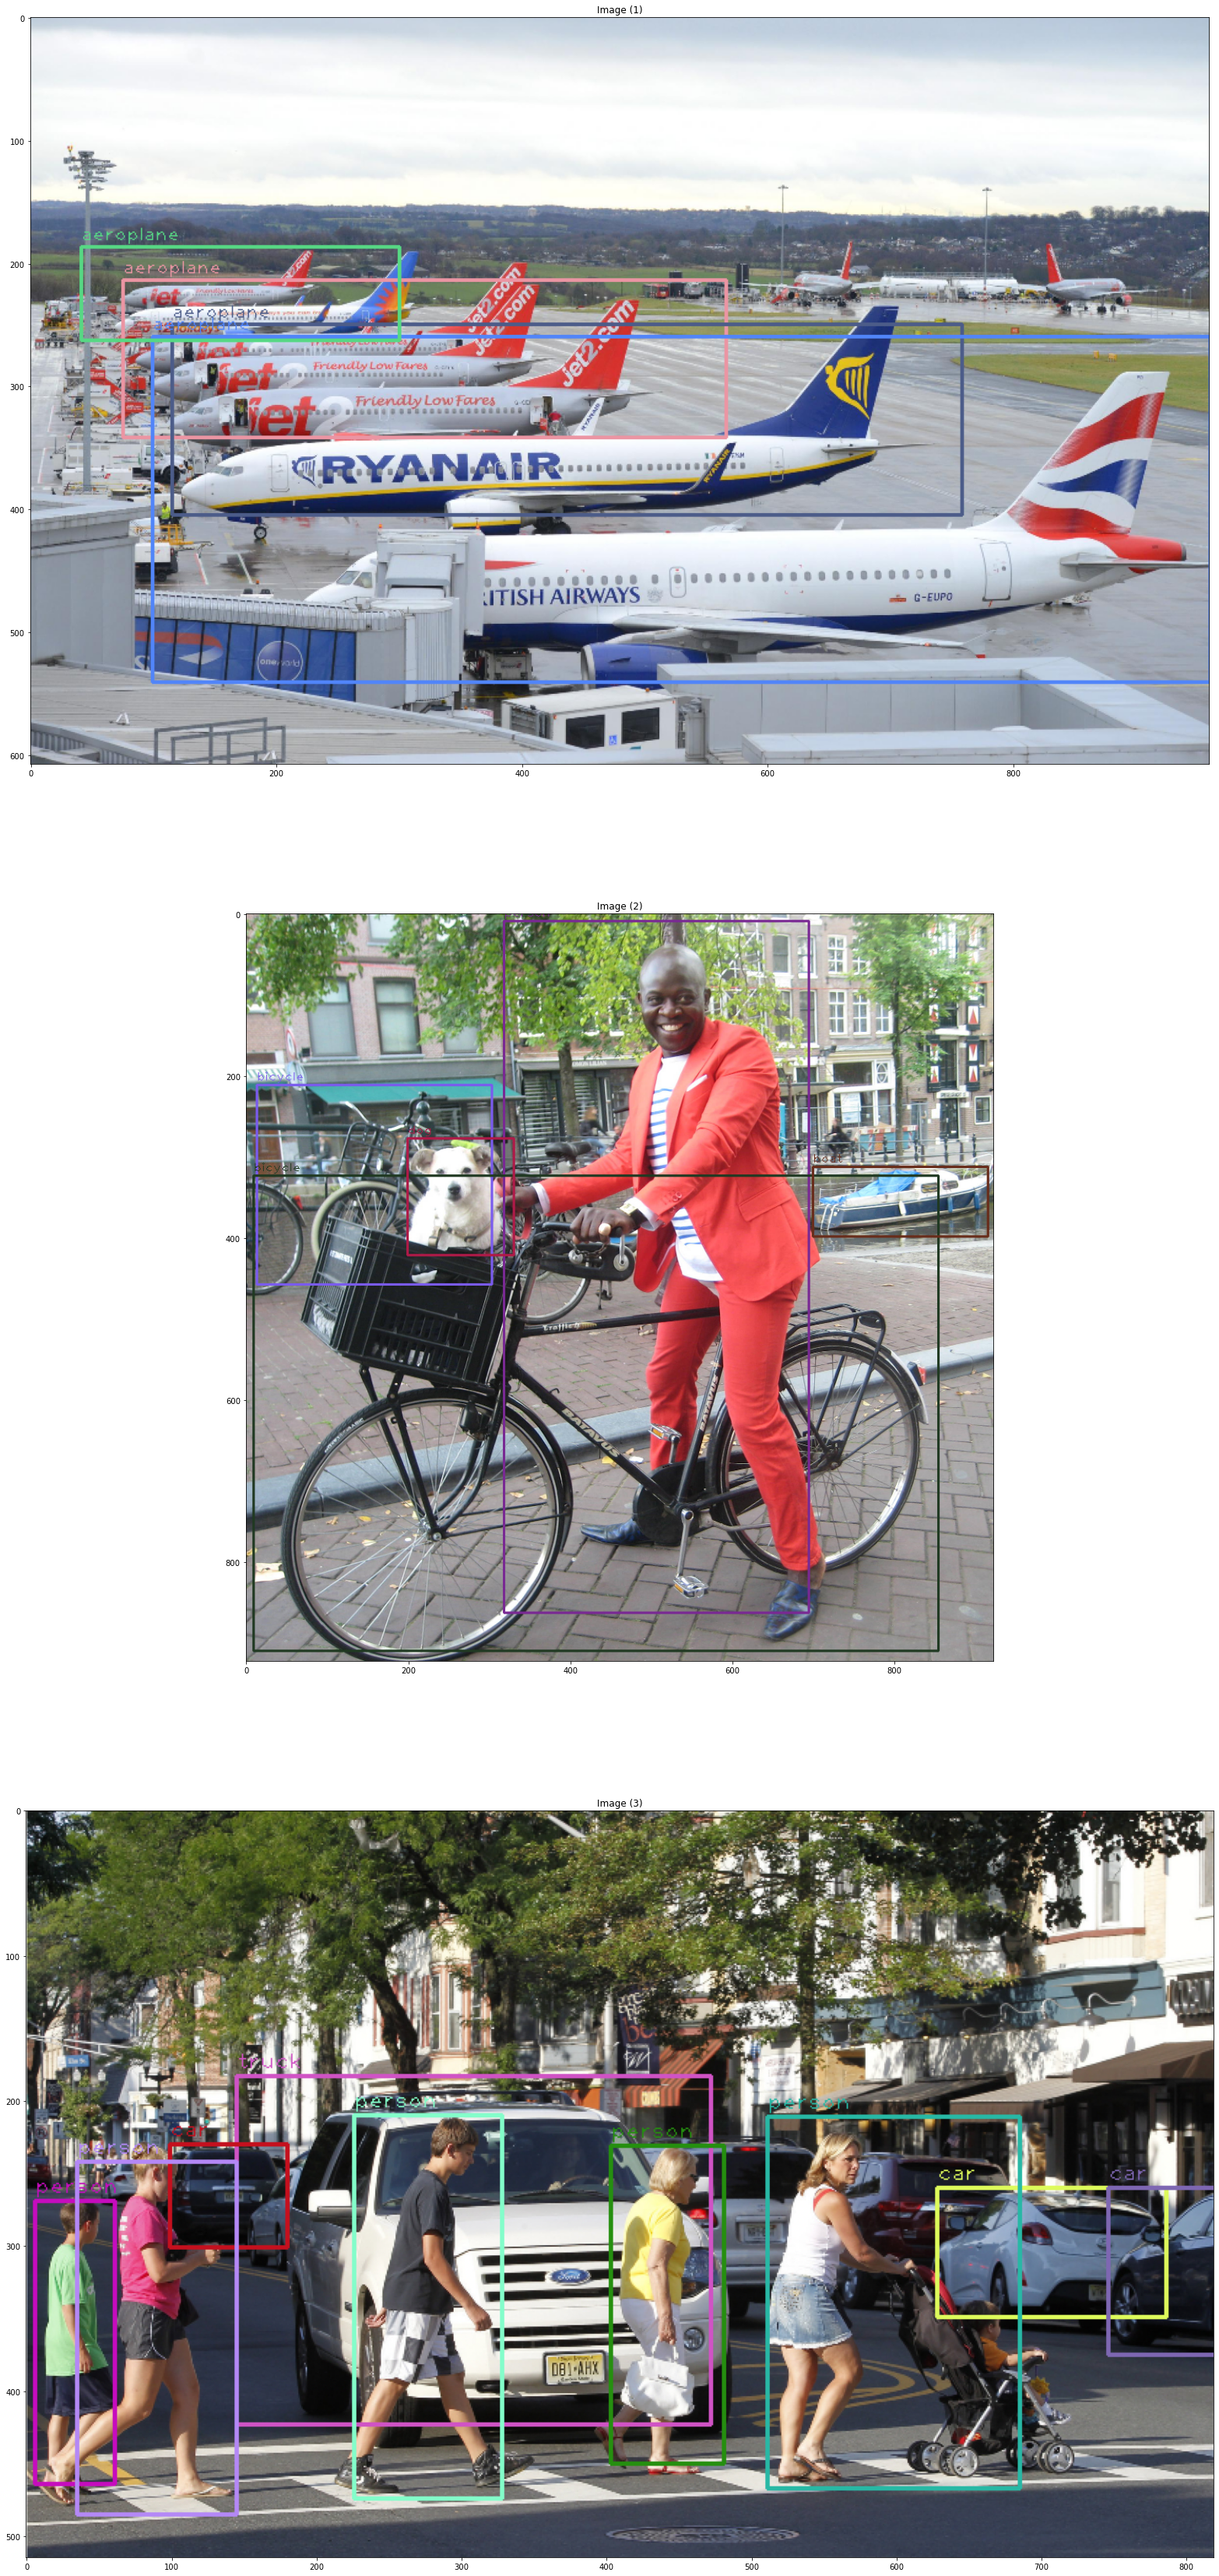

In [28]:
IMPORT_FILES = "./images/*.jpg"
files = glob.glob(IMPORT_FILES)

images = []
for file_path in files:
    image =  image_detect(file_path)
    images.append(image)
    
show_images(images)